Import Libraries

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

sns.set_style('whitegrid')
%matplotlib inline

Load Dataset

In [176]:
df = pd.read_csv("/content/Netflix Dataset.csv")

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("Columns:", df.columns.tolist())
df.head()

Columns: ['show_id', 'category', 'title', 'director', 'cast', 'country', 'release_date', 'rating', 'duration', 'type', 'description']


,show_id,category,title,director,cast,country,release_date,rating,duration,type,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


Parse Dates & Handle Missing

In [177]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

df['country'] = df['country'].fillna('Unknown')
df['category'] = df['category'].fillna('Unknown')
df['duration'] = df['duration'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Unknown')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       7789 non-null   object        
 1   category      7789 non-null   object        
 2   title         7789 non-null   object        
 3   director      5401 non-null   object        
 4   cast          7071 non-null   object        
 5   country       7789 non-null   object        
 6   release_date  7691 non-null   datetime64[ns]
 7   rating        7789 non-null   object        
 8   duration      7789 non-null   object        
 9   type          7789 non-null   object        
 10  description   7789 non-null   object        
 11  release_year  7691 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 730.3+ KB


Movies vs TV Shows Over Time

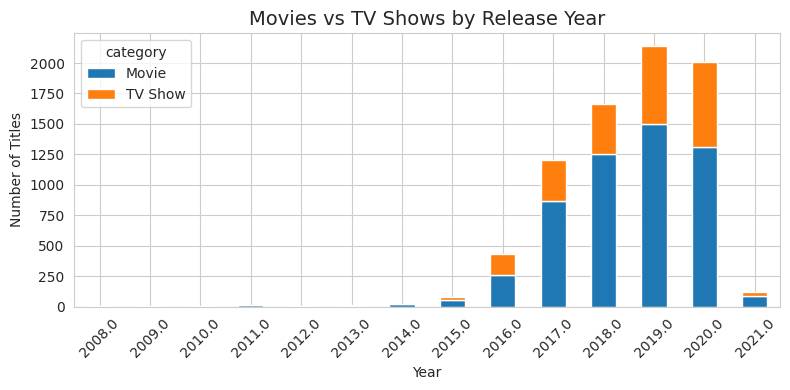

In [178]:
pv = (df.groupby(['release_year','category'])['title']
        .count().unstack(fill_value=0))

plt.figure(figsize=(8,4))
pv.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Movies vs TV Shows by Release Year', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Top Genres Over Time


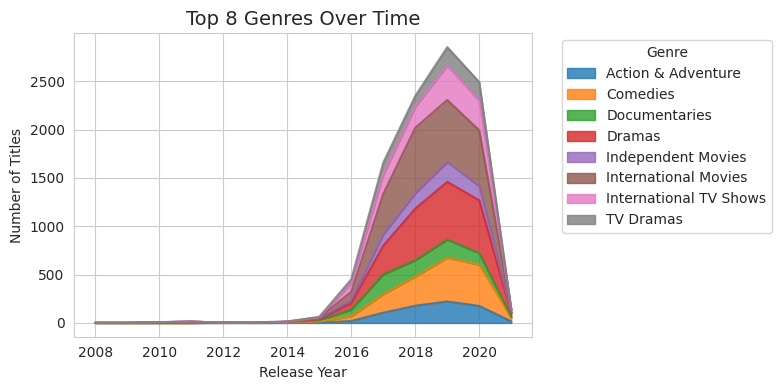

In [179]:
# Fill missing types
df['type'] = df['type'].fillna('Unknown')

# Split multiple genres and explode
df_genres = df.assign(genre=lambda d: d['type'].str.split(r',\s*')).explode('genre')
df_genres['genre'] = df_genres['genre'].str.strip()

# Top 8 genres
top_genres = df_genres['genre'].value_counts().nlargest(8).index

# Count titles per year for top genres
genre_year = (
    df_genres[df_genres['genre'].isin(top_genres)]
    .groupby(['release_year', 'genre'])['title']
    .count()
    .unstack(fill_value=0)
    .sort_index()
)

genre_year.plot.area(figsize=(8,4), alpha=0.8)
plt.title('Top 8 Genres Over Time', fontsize=14)
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Country Contributions

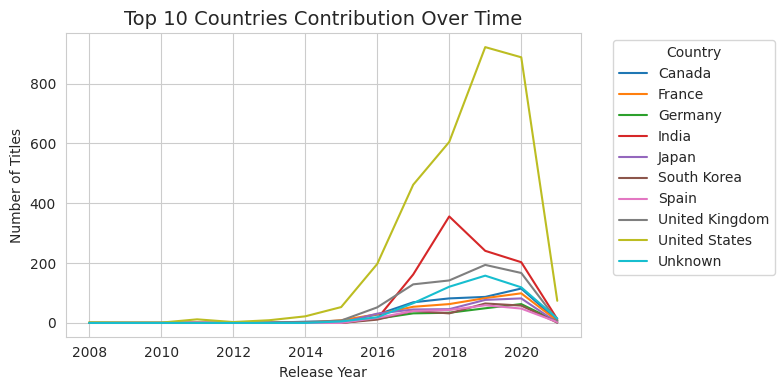

In [180]:
# Fix invalid escape sequence with raw string
df_countries = df.assign(
    country_split=lambda d: d['country'].str.split(r',\s*')
).explode('country_split')

# Remove leading/trailing whitespace
df_countries['country_split'] = df_countries['country_split'].str.strip()

# Get top 10 countries by frequency
top_countries = df_countries['country_split'].value_counts().nlargest(10).index

# Count titles per year for top countries
country_year = (
    df_countries[df_countries['country_split'].isin(top_countries)]
    .groupby(['release_year','country_split'])['title']
    .count()
    .unstack(fill_value=0)
    .sort_index()
)

country_year.plot(figsize=(8,4))
plt.title('Top 10 Countries Contribution Over Time', fontsize=14)
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

KPIs (Year-over-Year Growth)

              Total Titles  YoY % Growth
release_year                            
2012.0                   3        -76.92
2013.0                  10        233.33
2014.0                  24        140.00
2015.0                  79        229.17
2016.0                 432        446.84
2017.0                1201        178.01
2018.0                1661         38.30
2019.0                2137         28.66
2020.0                2009         -5.99
2021.0                 117        -94.18


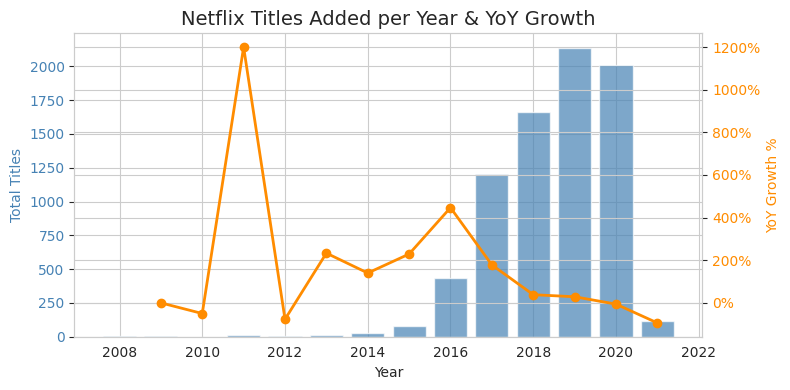

In [181]:
total_by_year = df.groupby('release_year')['title'].count().sort_index()
yoy = total_by_year.pct_change()*100
kpi_df = pd.DataFrame({'Total Titles': total_by_year, 'YoY % Growth': yoy.round(2)})

# Show last 10 years
print(kpi_df.tail(10))

# Plot Total Titles and YoY Growth together
fig, ax1 = plt.subplots(figsize=(8,4))

# Bar plot for total titles
ax1.bar(total_by_year.index, total_by_year.values, color="steelblue", alpha=0.7)
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Titles", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")

# Line plot for YoY growth on secondary axis
ax2 = ax1.twinx()
ax2.plot(yoy.index, yoy.values, color="darkorange", marker="o", linewidth=2, label="YoY Growth %")
ax2.set_ylabel("YoY Growth %", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")

# Format % axis
import matplotlib.ticker as mtick
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title("Netflix Titles Added per Year & YoY Growth", fontsize=14)
fig.tight_layout()
plt.show()

Correlation Matrix

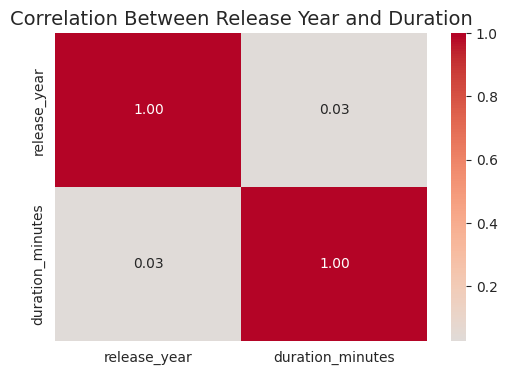

In [182]:
# Extract numeric duration (e.g., "90 min" → 90)
df['duration_minutes'] = df['duration'].str.extract(r'(\d+)').astype(float)

# Keep only numeric columns for correlation
numeric_df = df[['release_year','duration_minutes']].dropna()

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Between Release Year and Duration", fontsize=14)
plt.show()

Pairplot

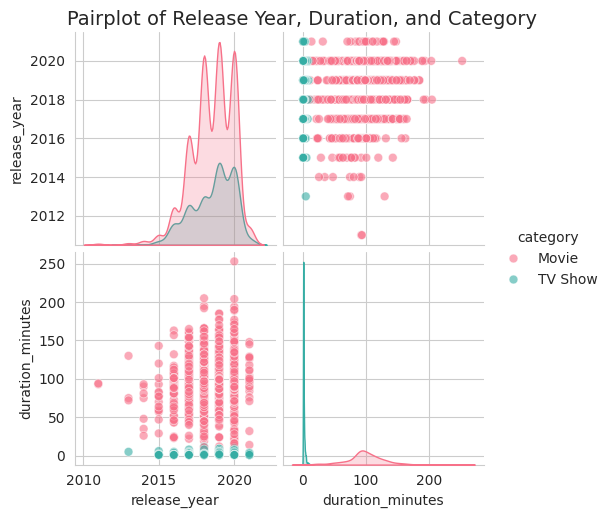

In [183]:
# Extract numeric duration (e.g., "90 min" → 90.0)
df['duration_minutes'] = df['duration'].str.extract(r'(\d+)').astype(float)

# Select relevant columns
pairplot_df = df[['release_year', 'duration_minutes', 'category']].dropna()

# Sample for performance if too large
pairplot_sample = (
    pairplot_df.sample(n=2000, random_state=42)
    if len(pairplot_df) > 2000
    else pairplot_df
)

# Create pairplot
sns.pairplot(
    pairplot_sample,
    hue="category",
    diag_kind="kde",
    palette="husl",
    plot_kws={"alpha":0.6, "s":40}  # better visibility
)

plt.suptitle("Pairplot of Release Year, Duration, and Category", y=1.02, fontsize=14)
plt.show()

Ratings Distribution

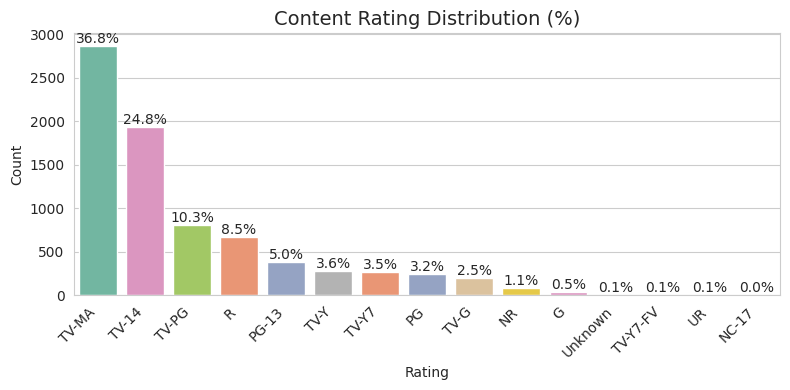

In [184]:
plt.figure(figsize=(8,4))
ax = sns.countplot(
    data=df,
    x='rating',
    hue='rating',
    legend=False,
    order=df['rating'].value_counts().index,
    palette="Set2"
)

# Annotate each bar with percentages
total = len(df)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.xticks(rotation=45, ha="right")
plt.title("Content Rating Distribution (%)", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Word Cloud of Titles

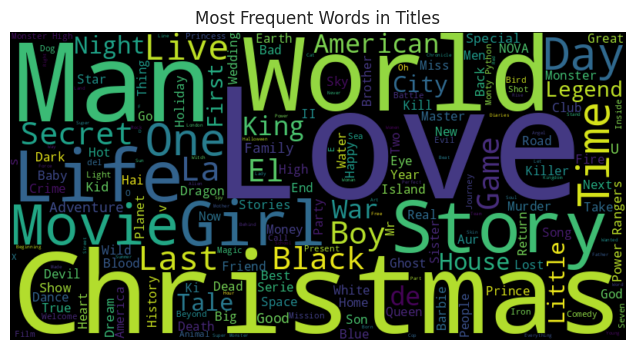

In [185]:
text = " ".join(df['title'].dropna())
wc = WordCloud(width=800, height=400, background_color="black").generate(text)

plt.figure(figsize=(8,4))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Titles")
plt.show()

Ratings Over Time

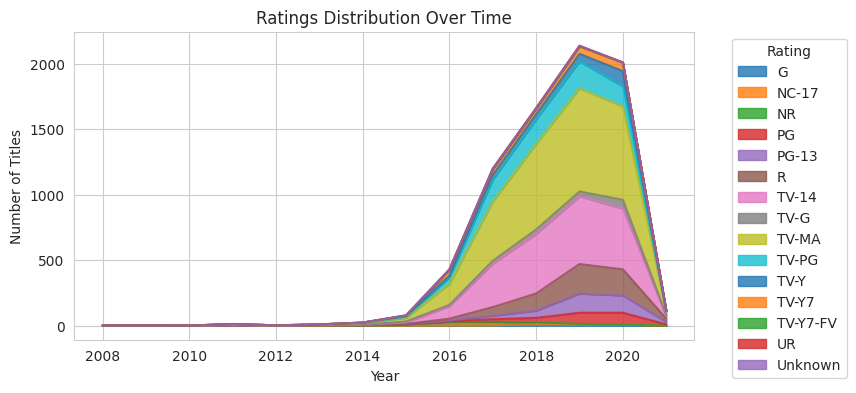

In [186]:
rating_year = df.groupby(['release_year','rating'])['title'].count().unstack(fill_value=0)
rating_year.plot.area(figsize=(8,4), alpha=0.8)
plt.title("Ratings Distribution Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Titles")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1))
plt.show()

Top Directors

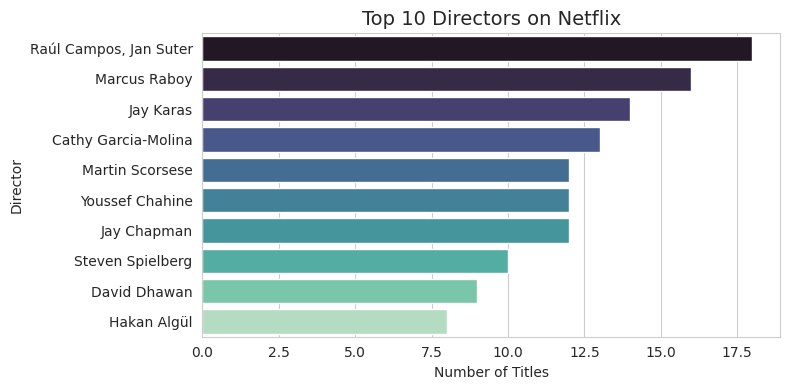

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

if 'director' in df.columns:
    # Get top 10 directors
    top_directors = df['director'].value_counts().nlargest(10)

    plt.figure(figsize=(8,4))
    sns.barplot(
        x=top_directors.values,
        y=top_directors.index,
        hue=top_directors.index,
        legend=False,
        palette="mako"
    )

    plt.xlabel("Number of Titles")
    plt.ylabel("Director")
    plt.title("Top 10 Directors on Netflix", fontsize=14)
    plt.tight_layout()
    plt.show()

Neural Network - Classification

In [188]:

from tensorflow.keras.callbacks import EarlyStopping

if 'category' in df.columns:
    df['category'] = df['category'].fillna('Unknown')  # fill missing
    le_cat = LabelEncoder()
    df['category_encoded'] = le_cat.fit_transform(df['category'])
else:
    raise ValueError("Column 'category' not found in DataFrame!")

features = ['release_year', 'duration_minutes']
X = df[features].fillna(0)
y = df['category_encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

num_classes = y.nunique()

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
])

if num_classes == 2:
    model.add(Dense(1, activation='sigmoid'))
    loss_fn = 'binary_crossentropy'
else:
    model.add(Dense(num_classes, activation='softmax'))
    loss_fn = 'sparse_categorical_crossentropy'

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9231 - loss: 0.3350 - val_accuracy: 0.9807 - val_loss: 0.0506
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9870 - loss: 0.0403 - val_accuracy: 0.9846 - val_loss: 0.0298
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9942 - loss: 0.0211 - val_accuracy: 0.9949 - val_loss: 0.0182
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0130 - val_accuracy: 0.9955 - val_loss: 0.0126
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0093 - val_accuracy: 0.9949 - val_loss: 0.0170
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9975 - loss: 0.0089 - val_accuracy: 0.9949 - val_loss: 0.0161
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 0.9955 - val_loss: 0.0117
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.0064 - val_accuracy: 0.

Model Performance Visualizations

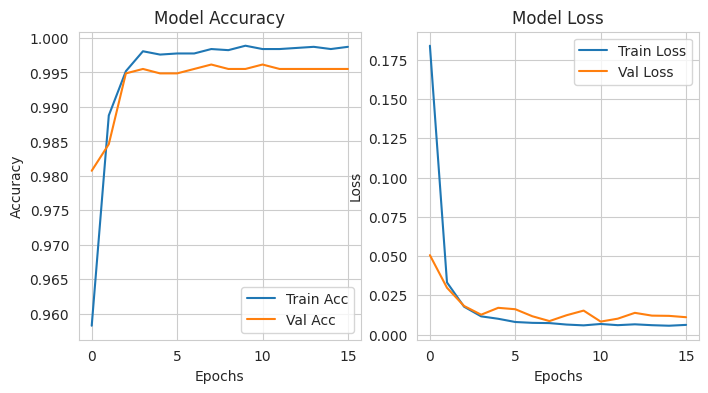

In [189]:
plt.figure(figsize=(8,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Scatter: Year vs Duration by Category

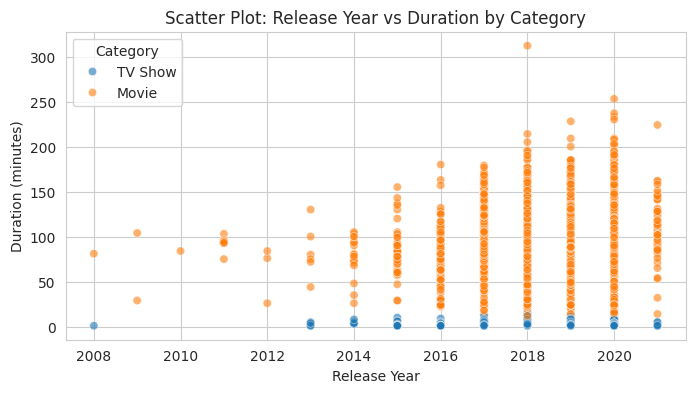

In [190]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=df['release_year'], y=df['duration_minutes'], hue=df['category'], alpha=0.6)
plt.title("Scatter Plot: Release Year vs Duration by Category")
plt.xlabel("Release Year")
plt.ylabel("Duration (minutes)")
plt.legend(title="Category")
plt.show()

Histogram: Duration

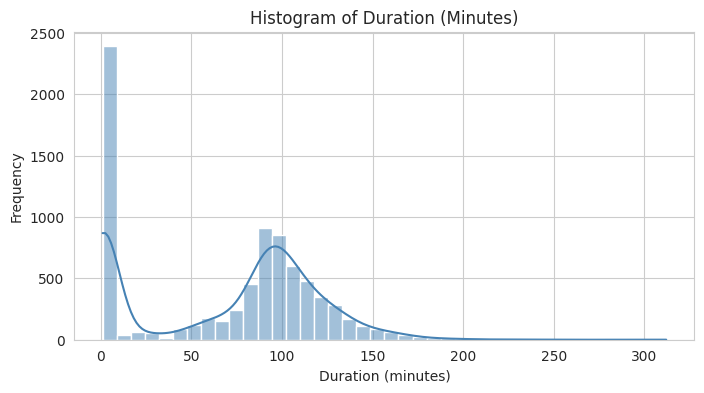

In [191]:
plt.figure(figsize=(8,4))
sns.histplot(df['duration_minutes'].dropna(), bins=40, kde=True, color="steelblue")
plt.title("Histogram of Duration (Minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

Confusion Matrix

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


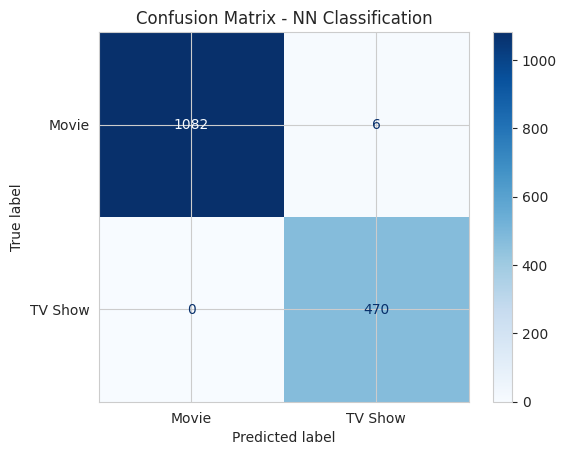

In [192]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_cat.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - NN Classification")
plt.show()

ROC Curve

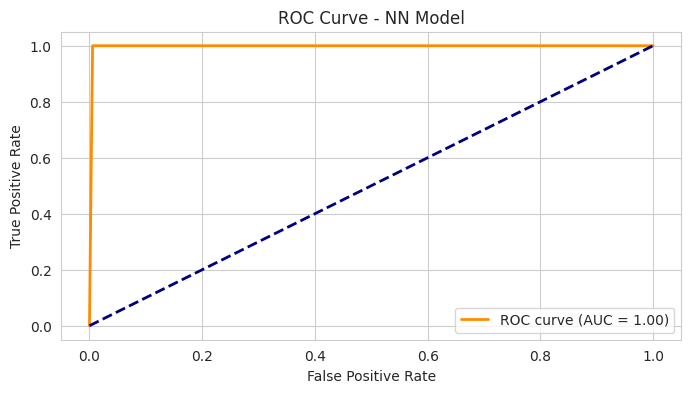

In [193]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - NN Model")
plt.legend(loc="lower right")
plt.show()

Insights & Recommendations

In [194]:
print("------------------- Insights & Recommendations---------------------")
print("- Movies dominated Netflix content until ~2015, but TV Shows started growing rapidly afterward, indicating a shift toward serialized content.")
print("- Top genres analysis shows sustained interest in Drama and Comedy, while niche genres (Documentary, Thriller) grew steadily.")
print("- US, India, and UK remain leading contributors, but international contributions have been rising since 2015, showing Netflix’s global expansion strategy.")
print("- Ratings distribution suggests a focus on family-friendly content (TV-MA, TV-14, TV-PG dominate).")
print("- Word Cloud shows common use of words like 'Love', 'World', 'Story' → reinforcing audience preference for relatable, emotional, or global narratives.")
print("- Directors analysis highlights a small cluster of recurring names driving much of Netflix’s output.")
print("\nRecommendation: Netflix should continue scaling international TV series while leveraging top-performing genres (Drama/Comedy). Investment in globally popular actors and directors could strengthen market reach.")


------------------- Insights & Recommendations---------------------
- Movies dominated Netflix content until ~2015, but TV Shows started growing rapidly afterward, indicating a shift toward serialized content.
- Top genres analysis shows sustained interest in Drama and Comedy, while niche genres (Documentary, Thriller) grew steadily.
- US, India, and UK remain leading contributors, but international contributions have been rising since 2015, showing Netflix’s global expansion strategy.
- Ratings distribution suggests a focus on family-friendly content (TV-MA, TV-14, TV-PG dominate).
- Word Cloud shows common use of words like 'Love', 'World', 'Story' → reinforcing audience preference for relatable, emotional, or global narratives.
- Directors analysis highlights a small cluster of recurring names driving much of Netflix’s output.

Recommendation: Netflix should continue scaling international TV series while leveraging top-performing genres (Drama/Comedy). Investment in globally popular

Optional Cast/Actor Analysis

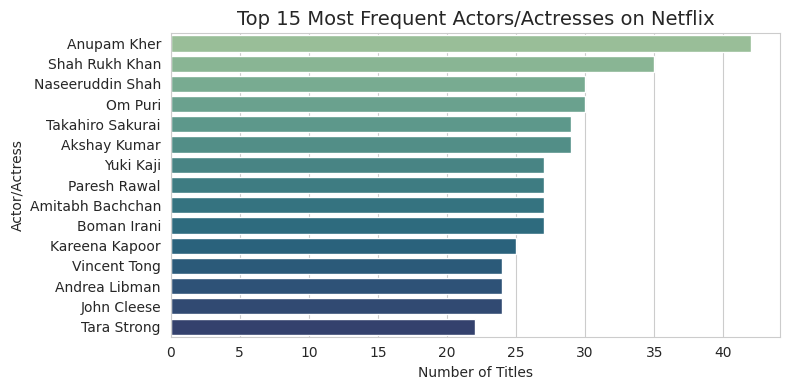

In [195]:
if 'cast' in df.columns:

    df_cast = df.assign(actor=lambda d: d['cast'].str.split(r',\s*')).explode('actor')
    df_cast['actor'] = df_cast['actor'].str.strip()


    top_actors = df_cast['actor'].value_counts().nlargest(15)

    plt.figure(figsize=(8,4))
    sns.barplot(
        x=top_actors.values,
        y=top_actors.index,
        hue=top_actors.index,
        legend=False,
        palette="crest"
    )

    plt.title("Top 15 Most Frequent Actors/Actresses on Netflix", fontsize=14)
    plt.xlabel("Number of Titles")
    plt.ylabel("Actor/Actress")
    plt.tight_layout()
    plt.show()